In [1]:
import numpy as np
import matplotlib.pyplot as plt
from corner import corner

seed = 42
np.random.seed(seed)

In [2]:
def powerlaw(x, slope, lo, hi):
    
    return (
        (x >= lo) * (x <= hi)
        * x**slope
        * (slope+1) / (hi**(slope+1) - lo**(slope+1))
        )

def sample_powerlaw(n_samples, slope, lo, hi):
    
    x = np.random.uniform(size=n_samples)
    
    return (lo**(slope+1) + x * (hi**(slope+1) - lo**(slope+1)))**(1/(slope+1))

def gaussian(x, mean=0., std=1.):
    
    return np.exp(-(x-mean)**2 / (2*std**2)) / (std * (2*np.pi)**.5)

In [3]:
n_slopes = 10
n_dim = 2
n_samples = 10000
lo = 0
hi = 1

slopes = np.linspace(0, 5, n_slopes)
data = sample_powerlaw([n_slopes, n_samples, n_dim], slopes[:, None, None], lo, hi)

slopes.shape, data.shape

((10,), (10, 10000, 2))

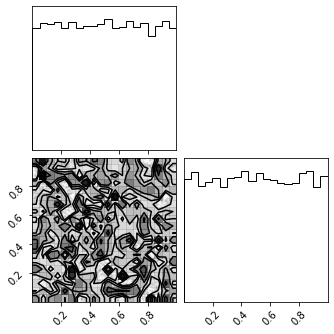

In [4]:
i = 0
corner(data[i]);

In [5]:
slopes = np.repeat(slopes[:, None, None], n_samples, axis=1)
slopes.shape

(10, 10000, 1)

In [6]:
slopes = slopes.reshape(-1, 1)
data = data.reshape(-1, n_dim)
slopes.shape, data.shape

((100000, 1), (100000, 2))

In [7]:
class Norm:
    
    def __init__(self, data):
        
        self.mean = np.mean(data, axis=0)
        self.std = np.std(data, axis=0)
        
    def forward(self, x):
        
        return (x - self.mean) / self.std
    
    def inverse(self, y):
        
        return y * self.std + self.mean

In [8]:
normalize = False

if normalize:
    slopes_norm = Norm(slopes)
    slopes = slopes_norm.forward(slopes)
    data_norm = Norm(data)
    data = data_norm.forward(data)
    
    i = 0
    corner(data[n_samples*i:n_samples*(i+1)]);

In [1]:
import copy
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data
from tqdm import tqdm

import pytorch_flows as fnn

device = torch.device('cpu')

In [10]:
batch_size = 100
epochs = 10
lr = 0.0001
num_inputs = n_dim
cond = True
num_cond_inputs = 1
num_hidden = 128
act = 'relu'
num_blocks = 3

In [11]:
train_tensor = torch.from_numpy(data.astype(np.float32))
train_labels = torch.from_numpy(slopes.astype(np.float32))
train_dataset = torch.utils.data.TensorDataset(
    train_tensor, train_labels,
    )

train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True,
    )

In [12]:
modules = []
for _ in range(num_blocks):
    modules += [
        fnn.MADE(num_inputs, num_hidden, num_cond_inputs, act=act),
        fnn.BatchNormFlow(num_inputs),
        fnn.Reverse(num_inputs),
        ]
model = fnn.FlowSequential(*modules)

for module in model.modules():
    if isinstance(module, nn.Linear):
        nn.init.orthogonal_(module.weight)
        if hasattr(module, 'bias') and module.bias is not None:
            module.bias.data.fill_(0)
            
model.to(device);

In [13]:
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-6)

global_step = 0

def train(epoch):
    
    global global_step
    model.train()
    train_loss = 0
    
    pbar = tqdm(total=len(train_loader.dataset))
    for batch_idx, data in enumerate(train_loader):
        if isinstance(data, list):
            if len(data) > 1:
                cond_data = data[1].float()
                cond_data = cond_data.to(device)
            else:
                cond_data = None
                
            data = data[0]
        data = data.to(device)
        optimizer.zero_grad()
        loss = -model.log_probs(data, cond_data).mean()
        train_loss += loss.item()
        loss.backward()
        optimizer.step()
        
        pbar.update(data.size(0))
        pbar.set_description(
            f'Train, log lkl in nats: {-train_loss/(batch_idx+1):.6f}',
            )
        
        global_step += 1
        
    pbar.close()
    
    for module in model.modules():
        if isinstance(module, fnn.BatchNormFlow):
            module.momentum = 0
            
    if cond:
        with torch.no_grad():
            model(
                train_loader.dataset.tensors[0].to(data.device),
                train_loader.dataset.tensors[1].to(data.device).float(),
                )
    else:
        with torch.no_grad():
            model(
                train_loader.dataset.tensors[0].to(data.device),
                )
    
    for module in model.modules():
        if isinstance(module, fnn.BatchNormFlow):
            module.momentum = 1
            
    return train_loss / len(train_loader.dataset)
            
best_train_loss = float('inf')
best_train_epoch = 0
best_model = model

for epoch in range(epochs):
    print(f'\nEpoch: {epoch}')
    
    train_loss = train(epoch)
    
#     if epoch - best_train_epoch >= 30:
#         break
        
    if train_loss < best_train_loss:
        best_train_epoch = epoch
        best_train_loss = train_loss
        best_model = copy.deepcopy(model)
        
    print(
        f'Best training epoch at {best_train_epoch}: ' \
        f'Average log lkl in nats: {-best_train_loss:.6f}',
        )


Epoch: 0


Train, log lkl in nats: 0.6137: 100%|████████████████████| 100000/100000 [00:09<00:00, 10279.09it/s]


Best training epoch at 0: Average log lkl in nats: 0.0061

Epoch: 1


Train, log lkl in nats: 0.8443: 100%|████████████████████| 100000/100000 [00:08<00:00, 11449.14it/s]


Best training epoch at 1: Average log lkl in nats: 0.0084

Epoch: 2


Train, log lkl in nats: 0.8642: 100%|████████████████████| 100000/100000 [00:08<00:00, 11290.87it/s]


Best training epoch at 2: Average log lkl in nats: 0.0086

Epoch: 3


Train, log lkl in nats: 0.8679: 100%|████████████████████| 100000/100000 [00:09<00:00, 10819.09it/s]


Best training epoch at 3: Average log lkl in nats: 0.0087

Epoch: 4


Train, log lkl in nats: 0.8695: 100%|████████████████████| 100000/100000 [00:08<00:00, 11155.94it/s]


Best training epoch at 4: Average log lkl in nats: 0.0087

Epoch: 5


Train, log lkl in nats: 0.8733: 100%|████████████████████| 100000/100000 [00:09<00:00, 11095.52it/s]


Best training epoch at 5: Average log lkl in nats: 0.0087

Epoch: 6


Train, log lkl in nats: 0.8746: 100%|████████████████████| 100000/100000 [00:09<00:00, 10601.36it/s]


Best training epoch at 6: Average log lkl in nats: 0.0087

Epoch: 7


Train, log lkl in nats: 0.8754: 100%|████████████████████| 100000/100000 [00:09<00:00, 10588.89it/s]


Best training epoch at 7: Average log lkl in nats: 0.0088

Epoch: 8


Train, log lkl in nats: 0.8774: 100%|████████████████████| 100000/100000 [00:09<00:00, 10320.24it/s]


Best training epoch at 8: Average log lkl in nats: 0.0088

Epoch: 9


Train, log lkl in nats: 0.8784: 100%|█████████████████████| 100000/100000 [00:10<00:00, 9879.40it/s]


Best training epoch at 9: Average log lkl in nats: 0.0088


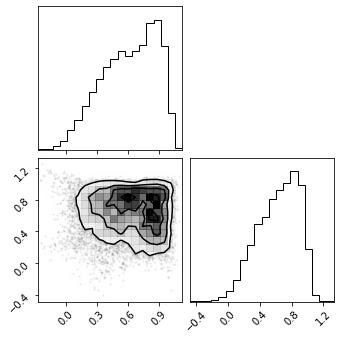

In [53]:
with torch.no_grad():
    corner(
        best_model.sample(10000, cond_inputs=train_dataset[10000][1]).numpy()
        );